In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

View 1: Photometric Mean (Total): 4.55px |Mean geometric pixel displacement: 0.000000 px
First 5 original rect points:
[[  0   0]
 [ 80   0]
 [120   0]
 [240   0]
 [280   0]]
First 5 reprojected rect points:
[[4.54747351e-13 2.27373675e-13]
 [8.00000000e+01 1.13686838e-13]
 [1.20000000e+02 1.13686838e-13]
 [2.40000000e+02 1.13686838e-13]
 [2.80000000e+02 3.41060513e-13]]


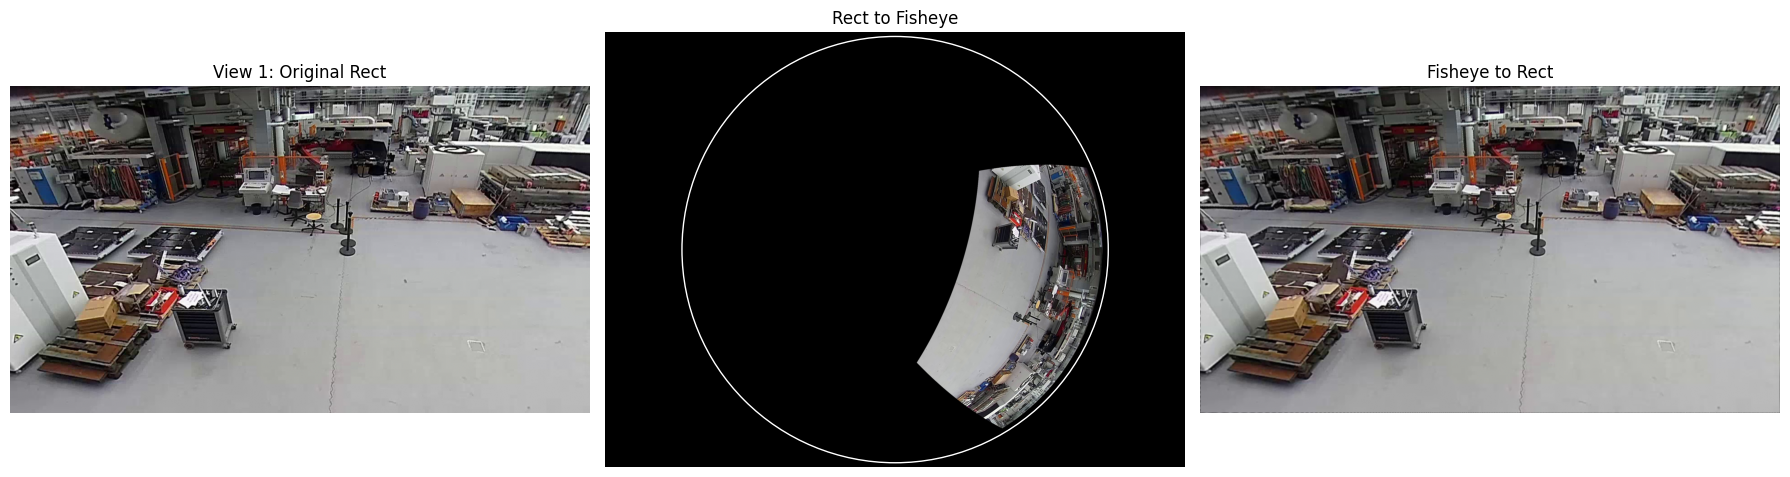

View 2: Photometric Mean (Total): 3.55px |Mean geometric pixel displacement: 0.000000 px
First 5 original rect points:
[[  0   0]
 [160   0]
 [200   0]
 [240   0]
 [280   0]]
First 5 reprojected rect points:
[[6.82121026e-13 4.54747351e-13]
 [1.60000000e+02 3.41060513e-13]
 [2.00000000e+02 1.13686838e-13]
 [2.40000000e+02 6.82121026e-13]
 [2.80000000e+02 4.54747351e-13]]


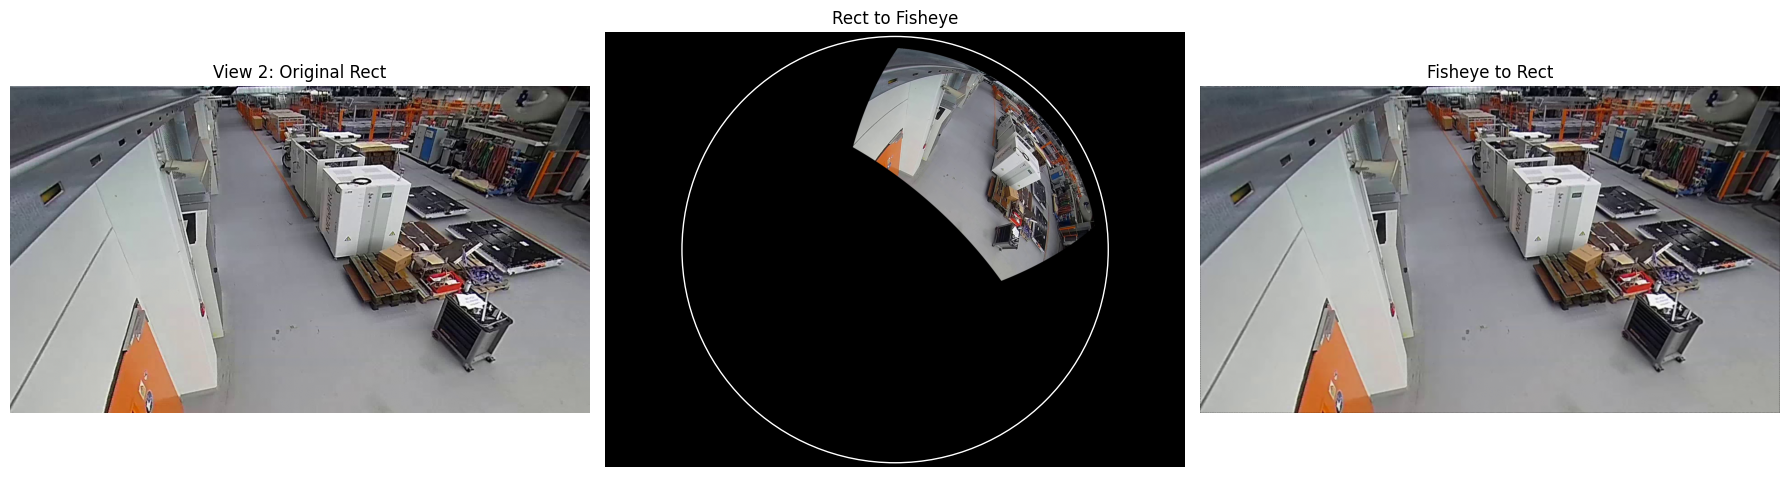

View 3: Photometric Mean (Total): 2.22px |Mean geometric pixel displacement: 0.000000 px
First 5 original rect points:
[[ 40   0]
 [ 80   0]
 [120   0]
 [200   0]
 [280   0]]
First 5 reprojected rect points:
[[4.00000000e+01 4.54747351e-13]
 [8.00000000e+01 2.27373675e-13]
 [1.20000000e+02 4.54747351e-13]
 [2.00000000e+02 1.13686838e-13]
 [2.80000000e+02 2.27373675e-13]]


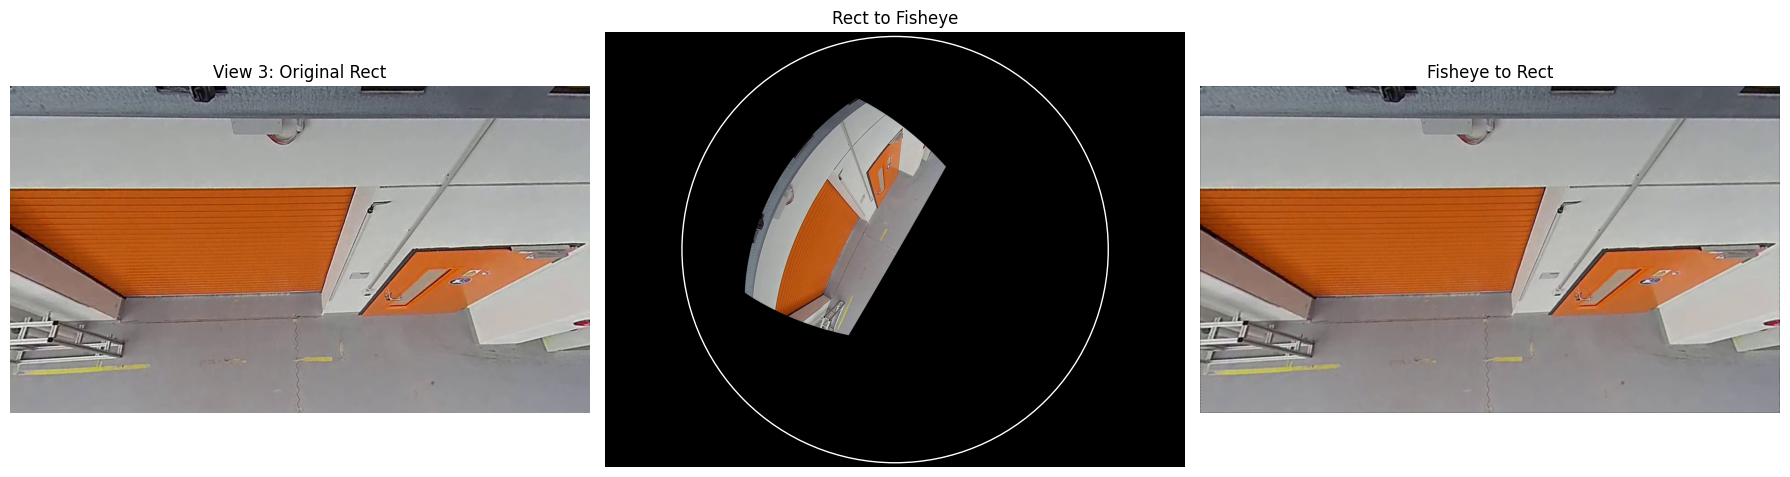

View 4: Photometric Mean (Total): 3.36px |Mean geometric pixel displacement: 0.000000 px
First 5 original rect points:
[[ 40   0]
 [ 80   0]
 [120   0]
 [160   0]
 [240   0]]
First 5 reprojected rect points:
[[4.00000000e+01 1.13686838e-13]
 [8.00000000e+01 1.13686838e-13]
 [1.20000000e+02 1.13686838e-13]
 [1.60000000e+02 1.13686838e-13]
 [2.40000000e+02 1.13686838e-13]]


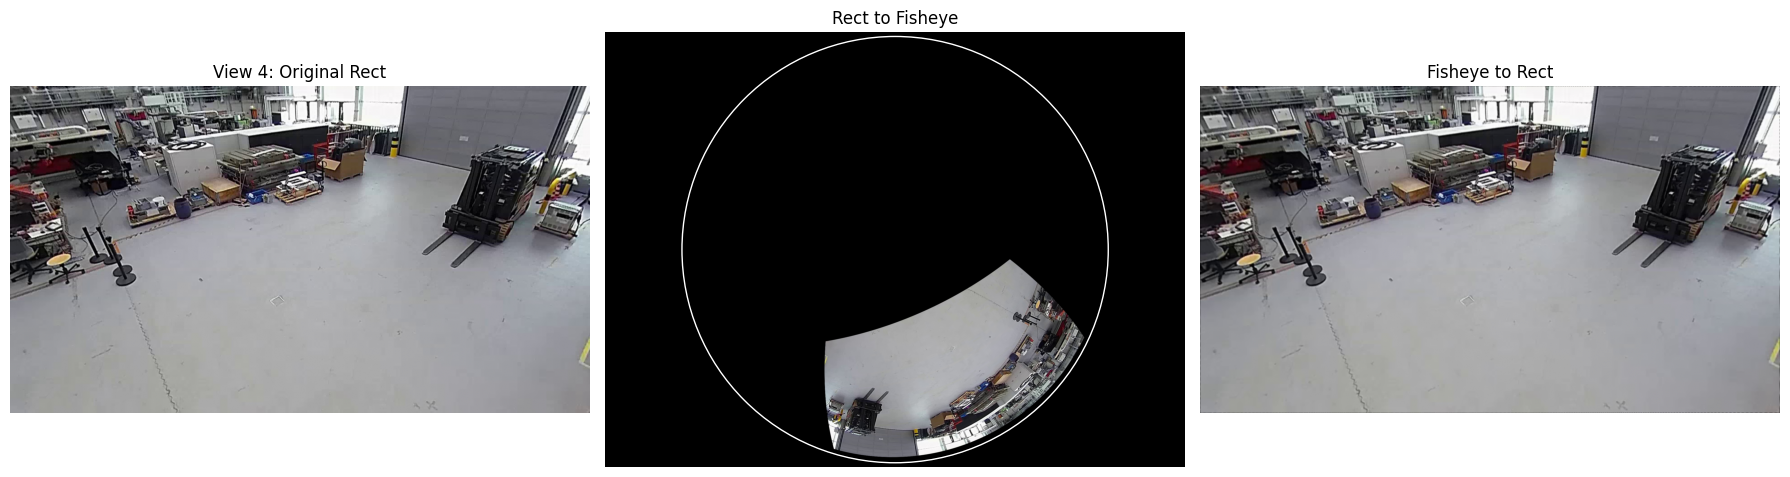

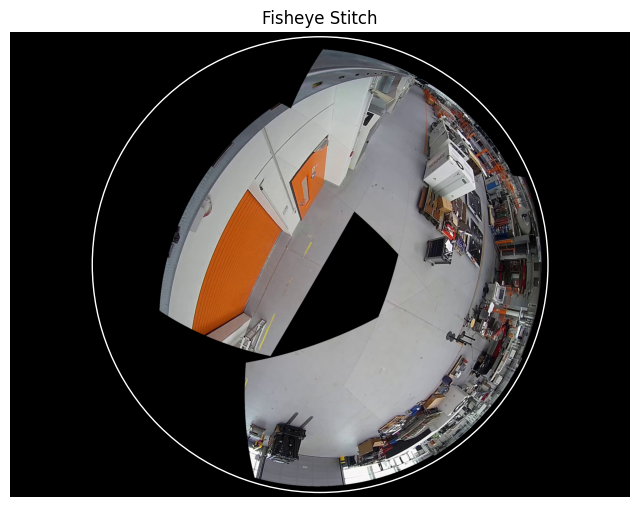

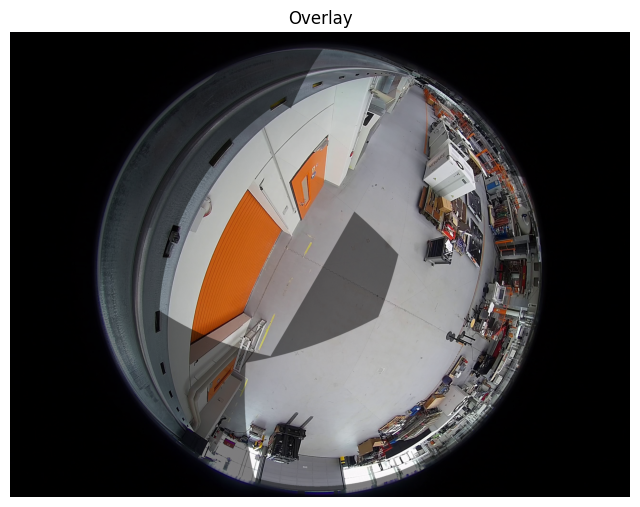

In [13]:
fisheye_params = {
    "width": 2592,
    "height": 1944,
    "cx": 1296.0,
    "cy": 972.0,
    "radius": 952.56,
    "theta_max_rad": 1.5708
}

cam_settings = [
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": -18.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 54.0, "yaw": 48.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 28.0, "yaw": 150.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": 294.0},
]
views_path = [
    "captures_yaw_pitch/capture1/view1_1.jpg",
    "captures_yaw_pitch/capture1/view2_1.jpg",
    "captures_yaw_pitch/capture1/view3_1.jpg",
    "captures_yaw_pitch/capture1/view4_1.jpg"
]
fisheye_path = "captures_yaw_pitch/capture1/fisheye_1.jpg"

def load_images(views, fisheye_path=None):
    image_bgr = []
    for p in views:
        b = cv2.imread(p)
        if b is None:
            raise FileNotFoundError(f"Missing {p}")
        image_bgr.append(b)
    fisheye_img = None
    if fisheye_path:
        fisheye_img = cv2.imread(fisheye_path)
        
    return image_bgr, fisheye_img
views, fisheye_img = load_images(views_path, fisheye_path)
fisheye_img = cv2.cvtColor(fisheye_img, cv2.COLOR_BGR2RGB) / 255.0
views = [cv2.cvtColor(v, cv2.COLOR_BGR2RGB) / 255.0 for v in views]



def compute_basis(yaw_deg, pitch_deg):
    yaw_deg_corrected = yaw_deg - 90.0
    yaw, pitch = np.deg2rad([yaw_deg_corrected, pitch_deg])
    Rz = np.array([
        [ np.cos(-yaw), -np.sin(-yaw), 0],
        [ np.sin(-yaw),  np.cos(-yaw), 0],
        [ 0,             0,            1]
    ])
    Rx = np.array([
        [ 1, 0,           0          ],
        [ 0, np.cos(pitch), -np.sin(pitch)],
        [ 0, np.sin(pitch),  np.cos(pitch)]
    ])
    R_ = Rx @ Rz
    R = np.diag([1, -1, 1]) @ R_
    return R


def project_rect_to_fisheye(rect_img, view, fish):
    Hr, Wr = 720,1280
    Hf, Wf = fish["height"], fish["width"]
    cx_f, cy_f = fish["cx"], fish["cy"]
    radius, theta_max = fish["radius"], fish["theta_max_rad"]
    cx_r, cy_r = Wr / 2, Hr / 2
    f = (Wr / 2) / np.tan(np.deg2rad(view["fov"] / 2))
    Rot = compute_basis(view["yaw"], view["pitch"])
    xs, ys = np.meshgrid(np.arange(Wf), np.arange(Hf))
    dx, dy = xs - cx_f, cy_f - ys
    r = np.sqrt(dx**2 + dy**2)
    theta = (r / radius) * theta_max
    phi = np.arctan2(dy, dx)
    sin_t = np.sin(theta)
    ray = np.dstack([sin_t * np.cos(phi),
                     sin_t * np.sin(phi),
                     np.cos(theta)])
    ray_rect = ray @ Rot.T
    Xc, Yc, Zc = ray_rect[..., 0], ray_rect[..., 1], ray_rect[..., 2]
    u = f * (Xc / (Zc + 1e-6)) + cx_r
    v = f * (Yc / (Zc + 1e-6)) + cy_r
    valid = (u >= 0) & (u < Wr) & (v >= 0) & (v < Hr) & (r <= radius) & (Zc > 0)

    warped = cv2.remap(rect_img, u.astype(np.float32), v.astype(np.float32),
                       cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    mask = np.zeros((Hf, Wf), np.uint8); mask[valid] = 1
    return warped, mask


def fisheye_to_rect_inverse(fish_img, view, fish):
    Hr, Wr = 720, 1280
    Hf, Wf = fish["height"], fish["width"]
    cx_f, cy_f = fish["cx"], fish["cy"]
    radius, theta_max = fish["radius"], fish["theta_max_rad"]
    cx_r, cy_r = Wr / 2, Hr / 2
    f = (Wr / 2) / np.tan(np.deg2rad(view["fov"] / 2))
    Rot = compute_basis(view["yaw"], view["pitch"])
    xs, ys = np.meshgrid(np.arange(Wr), np.arange(Hr))
    ray = np.stack([(xs - cx_r) / f, (ys - cy_r) / f, np.ones_like(xs)], axis=-1)
    ray /= np.linalg.norm(ray, axis=2, keepdims=True)
    ray_fish = ray @ Rot
    Xf, Yf, Zf = ray_fish[..., 0], ray_fish[..., 1], ray_fish[..., 2]
    theta = np.arccos(np.clip(Zf, -1, 1))
    phi = np.arctan2(Yf, Xf)
    r = (theta / theta_max) * radius
    u = cx_f + r * np.cos(phi)
    v = cy_f - r * np.sin(phi)
    valid = (u >= 0) & (u < Wf) & (v >= 0) & (v < Hf)

    rectified = cv2.remap(fish_img, u.astype(np.float32), v.astype(np.float32),
                          cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    mask = np.zeros((Hr, Wr), np.uint8); mask[valid] = 1
    return rectified, mask


## Error Calculation

def geometric_displacement(rect_img, params, fisheye_params, step=40):
    Hr, Wr = rect_img.shape[:2]
    ys, xs = np.mgrid[0:Hr:step, 0:Wr:step]
    coords = np.stack([xs.ravel(), ys.ravel()], axis=-1)
    f = (Wr / 2) / np.tan(np.deg2rad(params["fov"] / 2))
    cx_r, cy_r = params["cx"], params["cy"]
    Rmat = compute_basis(params["yaw"], params["pitch"])
    x = (coords[:, 0] - cx_r) / f
    y = (coords[:, 1] - cy_r) / f
    z = np.ones_like(x)
    ray = np.stack([x, y, z], axis=1)
    ray /= np.linalg.norm(ray, axis=1, keepdims=True)
    ray_fish = ray @ Rmat.T
    theta_max = fisheye_params["theta_max_rad"]
    radius = fisheye_params["radius"]
    cx_f, cy_f = fisheye_params["cx"], fisheye_params["cy"]

    # Fisheye projection (rect->fish)
    Xf, Yf, Zf = ray_fish[:, 0], ray_fish[:, 1], ray_fish[:, 2]
    theta = np.arccos(np.clip(Zf, -1, 1))
    phi = np.arctan2(Yf, Xf)
    r = (theta / theta_max) * radius
    u_fish = cx_f + r * np.cos(phi)
    v_fish = cy_f - r * np.sin(phi)
    sin_t = np.sin(theta)
    ray_back_fish = np.stack([sin_t * np.cos(phi),
                              sin_t * np.sin(phi),
                              np.cos(theta)], axis=1)
    ray_back_rect = ray_back_fish @ Rmat
    Xc, Yc, Zc = ray_back_rect[:, 0], ray_back_rect[:, 1], ray_back_rect[:, 2]
    u_back = f * (Xc / Zc) + cx_r
    v_back = f * (Yc / Zc) + cy_r


    valid = (Zc > 0) & (u_back >= 0) & (u_back < Wr) & (v_back >= 0) & (v_back < Hr)
    coords_valid = coords[valid]
    u_back_valid, v_back_valid = u_back[valid], v_back[valid]
    disp = np.sqrt((coords[:, 0] - u_back)**2 + (coords[:, 1] - v_back)**2)
    mean_disp = np.mean(disp[valid])

    return coords_valid, np.stack([u_back_valid, v_back_valid], axis=1), mean_disp

Hf, Wf = fisheye_params["height"], fisheye_params["width"]
cx_f, cy_f = fisheye_params["cx"], fisheye_params["cy"]
radius = fisheye_params["radius"]

fisheye_canvas = np.zeros((Hf, Wf, 3), dtype=np.float32)
weight_mask = np.zeros((Hf, Wf, 1), dtype=np.float32)

for i, params in enumerate(cam_settings):
    rect_img = cv2.resize(views[i], (1280, 720))
    warped, mask = project_rect_to_fisheye(rect_img, params, fisheye_params)
    rect_back, valid_back = fisheye_to_rect_inverse(warped, params, fisheye_params)

    yy, xx = np.mgrid[0:warped.shape[0], 0:warped.shape[1]]
    circle_mask = ((xx - cx_f)**2 + (yy - cy_f)**2) <= radius**2
    warped_circle = warped.copy()
    warped_circle[~circle_mask] = 0

    coords_orig, coords_back, mean_disp = geometric_displacement(rect_img, params, fisheye_params)

    diff = np.linalg.norm((rect_img - rect_back), axis=2)
    valid_mask = valid_back > 0
    diff_valid = diff[valid_mask]
    photo_mean = np.mean(diff_valid)*255 
    print(f"View {i+1}: Photometric Mean (Total): {photo_mean:.2f}px |Mean geometric pixel displacement: {mean_disp:.6f} px")
    print("First 5 original rect points:")
    print(coords_orig[:5])
    print("First 5 reprojected rect points:")
    print(coords_back[:5])


    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(rect_img)
    plt.title(f"View {i+1}: Original Rect")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(warped_circle)
    circ = plt.Circle((cx_f, cy_f), radius, color=(1,1,1), fill=False, linewidth=1)
    plt.gca().add_patch(circ)
    plt.title("Rect to Fisheye")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(rect_back)
    plt.title("Fisheye to Rect")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    mask3 = mask[..., None].astype(np.float32)
    fisheye_canvas += warped * mask3
    weight_mask += mask3

weight_mask[weight_mask == 0] = 1
fisheye_stitched = fisheye_canvas / weight_mask
yy, xx = np.mgrid[0:Hf, 0:Wf]
circle_mask = ((xx - cx_f)**2 + (yy - cy_f)**2) <= radius**2
fisheye_stitched[~circle_mask] = 0

plt.figure(figsize=(8,8))
plt.imshow(fisheye_stitched)
circ = plt.Circle((fisheye_params["cx"], fisheye_params["cy"]),
                    fisheye_params["radius"], color=(1,1,1), fill=False, linewidth=1)
plt.gca().add_patch(circ)
plt.title("Fisheye Stitch")
plt.axis("off")
plt.show()

overlay = 0.5 * fisheye_stitched + 0.5 * fisheye_img
plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")
plt.show()



In [ ]:

fisheye_params = {
    "width": 2592,
    "height": 1944,
    "cx": 1296.0,
    "cy": 972.0,
    "radius": 952.56,
    "theta_max_rad": 1.5708
}


cam_settings = [
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": -18.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 54.0, "yaw": 48.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 28.0, "yaw": 150.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": 294.0},
]


views_path = [
    "captures_yaw_pitch/capture1/view1_1.jpg",
    "captures_yaw_pitch/capture1/view2_1.jpg",
    "captures_yaw_pitch/capture1/view3_1.jpg",
    "captures_yaw_pitch/capture1/view4_1.jpg"
]
fisheye_path = "captures_yaw_pitch/capture1/fisheye_1.jpg"

def load_images(views, fisheye_path=None):
    image_bgr = []
    for p in views:
        b = cv2.imread(p)
        if b is None:
            raise FileNotFoundError(f"Missing {p}")
        image_bgr.append(b)
    fisheye_img = None
    if fisheye_path:
        fisheye_img = cv2.imread(fisheye_path)
        
    return image_bgr, fisheye_img
views, fisheye_img = load_images(views_path, fisheye_path)

def compute_basis(yaw_deg, pitch_deg):
    yaw_deg_corrected = yaw_deg - 90.0
    yaw, pitch = np.deg2rad([yaw_deg_corrected, pitch_deg])

    Rz = np.array([
        [ np.cos(-yaw), -np.sin(-yaw), 0],
        [ np.sin(-yaw),  np.cos(-yaw), 0],
        [ 0,             0,            1]
    ])
    Rx = np.array([
        [ 1, 0,           0          ],
        [ 0, np.cos(pitch), -np.sin(pitch)],
        [ 0, np.sin(pitch),  np.cos(pitch)]
    ])
    R_ = Rx @ Rz
    R = np.diag([1, -1, 1]) @ R_
    return R

def rect_to_fisheye_point(u, v, view_params, fisheye_params):
    Hr, Wr = 720, 1280
    cx_r, cy_r = Wr / 2, Hr / 2
    fov = view_params["fov"]
    f = (Wr / 2) / np.tan(np.deg2rad(fov / 2))
    x = (u - cx_r) / f
    y = (v - cy_r) / f
    z = 1
    ray_rect = np.array([x, y, z])
    ray_rect /= np.linalg.norm(ray_rect)
    Rot = compute_basis(view_params["yaw"], view_params["pitch"])
    ray_fish = Rot.T @ ray_rect
    Xf, Yf, Zf = ray_fish
    theta = np.arccos(np.clip(Zf, -1, 1))
    phi = np.arctan2(Yf, Xf)
    radius, theta_max = fisheye_params["radius"], fisheye_params["theta_max_rad"]
    cx_f, cy_f = fisheye_params["cx"], fisheye_params["cy"]
    r = (theta / theta_max) * radius
    u_f = cx_f + r * np.cos(phi)
    v_f = cy_f - r * np.sin(phi)
    return (int(u_f), int(v_f))

def fisheye_to_rect_point(u_f, v_f, view_params, fisheye_params):
    cx_f, cy_f = fisheye_params["cx"], fisheye_params["cy"]
    radius, theta_max = fisheye_params["radius"], fisheye_params["theta_max_rad"]

    dx, dy = u_f - cx_f, cy_f - v_f
    r = np.sqrt(dx ** 2 + dy ** 2)
    theta = (r / radius) * theta_max
    phi = np.arctan2(dy, dx)
    sin_t = np.sin(theta)
    ray_fish = np.array([sin_t * np.cos(phi), 
                         sin_t * np.sin(phi), 
                         np.cos(theta)])
    Rot = compute_basis(view_params["yaw"], view_params["pitch"])
    ray_rect = Rot @ ray_fish

    Xc, Yc, Zc = ray_rect
    if Zc <= 0:
        return None

    Hr, Wr = 720, 1280
    fov = view_params["fov"]
    f = (Wr / 2) / np.tan(np.deg2rad(fov / 2))
    cx_r, cy_r = Wr / 2, Hr / 2
    u = f * (Xc / Zc) + cx_r
    v = f * (Yc / Zc) + cy_r
    if 0 <= u < Wr and 0 <= v < Hr:
        return (int(u), int(v))
    return None


## Display
FISH_W_DISP, FISH_H_DISP = 1280, 720
RECT_TILE_W_DISP, RECT_TILE_H_DISP = 640, 360

fisheye_display = cv2.resize(fisheye_img, (FISH_W_DISP, FISH_H_DISP))
views_disp = [cv2.resize(v, (RECT_TILE_W_DISP, RECT_TILE_H_DISP)) for v in views]

scale_fx = fisheye_params["width"] / FISH_W_DISP
scale_fy = fisheye_params["height"] / FISH_H_DISP

def make_rect_grid_disp():
    grid = np.ones((RECT_TILE_H_DISP * 2, RECT_TILE_W_DISP * 2, 3), dtype=np.uint8) * 30
    grid[0:RECT_TILE_H_DISP, 0:RECT_TILE_W_DISP] = views_disp[0]
    grid[0:RECT_TILE_H_DISP, RECT_TILE_W_DISP:] = views_disp[1]
    grid[RECT_TILE_H_DISP:, 0:RECT_TILE_W_DISP] = views_disp[2]
    grid[RECT_TILE_H_DISP:, RECT_TILE_W_DISP:] = views_disp[3]
    return grid

rect_grid_disp = make_rect_grid_disp()

def draw_text(img, text, pos, color=(255, 255, 255)):
    font = cv2.FONT_HERSHEY_COMPLEX  
    scale = 0.8                 
    thickness = 2         
    x, y = int(pos[0]), int(pos[1])
    cv2.putText(img, text, (x + 1, y + 1), font, scale, (0, 0, 0), thickness , cv2.LINE_AA)
    cv2.putText(img, text, (x, y), font, scale, color, thickness, cv2.LINE_AA)

def on_mouse(event, x, y, flags, param):
    global canvas
    if event != cv2.EVENT_LBUTTONDOWN:
        return

    fisheye_disp = fisheye_display.copy()
    rect_disp = rect_grid_disp.copy()

    if x < FISH_W_DISP:  
        u_full, v_full = x * scale_fx, y * scale_fy
        cv2.circle(fisheye_disp, (x, y), 3, (0, 255, 0), -1)
        draw_text(fisheye_disp, f"({u_full:.1f},{v_full:.1f})", (x, y), (0, 255, 0))
        print(f"Click Fisheye_point=({u_full:.1f},{v_full:.1f})")

        for i, cam in enumerate(cam_settings):
            pt = fisheye_to_rect_point(u_full, v_full, cam, fisheye_params)
            if pt is not None:
                u_rect, v_rect = pt
                ox = (i % 2) * RECT_TILE_W_DISP
                oy = (i // 2) * RECT_TILE_H_DISP
                u_disp, v_disp = int(u_rect / 2), int(v_rect / 2)
                pos = (ox + u_disp, oy + v_disp)
                cv2.circle(rect_disp, pos, 3, (0, 0, 255), -1)
                draw_text(rect_disp, f"({u_rect},{v_rect})", pos, (0, 0, 255))
                print(f" Rect view {i+1}: Rect_point=({u_rect:.1f},{v_rect:.1f}) ")

    else: 
        xr = x - FISH_W_DISP
        xi = xr % RECT_TILE_W_DISP
        yi = y % RECT_TILE_H_DISP
        view_idx = (y >= RECT_TILE_H_DISP) * 2 + (xr >= RECT_TILE_W_DISP)
        u_full, v_full = xi * 2, yi * 2
        print(f"Click Rect_point=({u_full},{v_full}) ")
        draw_text(rect_disp, f"({u_full},{v_full})", (x - FISH_W_DISP, y), (0, 255, 0))
        cv2.circle(rect_disp, (x - FISH_W_DISP, y), 3, (0, 255, 0), -1)
        pt_f = rect_to_fisheye_point(u_full, v_full, cam_settings[view_idx], fisheye_params)
        if pt_f is not None:
            u_f, v_f = pt_f
            u_fd, v_fd = int(u_f / scale_fx), int(v_f / scale_fy)
            cv2.circle(fisheye_disp, (u_fd, v_fd), 3, (0, 0,255), -1)
            draw_text(fisheye_disp, f"({int(u_f)},{int(v_f)})", (u_fd, v_fd), (0, 0, 255))
            print(f" Fisheye_point=({int(u_f)},{int(v_f)})")

    canvas = np.ones((max(FISH_H_DISP, rect_disp.shape[0]), FISH_W_DISP + rect_disp.shape[1], 3), dtype=np.uint8) * 255
    canvas[0:FISH_H_DISP, 0:FISH_W_DISP] = fisheye_disp
    canvas[0:rect_disp.shape[0], FISH_W_DISP:] = rect_disp

    cv2.imshow("Unified Mapping", canvas)

canvas = np.ones((720, 2560, 3), dtype=np.uint8) * 255
canvas[0:720, 0:1280] = fisheye_display
canvas[0:720, 1280:] = rect_grid_disp

cv2.namedWindow("Unified Mapping", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Unified Mapping", on_mouse)
cv2.imshow("Unified Mapping", canvas)

while True:
    if cv2.waitKey(20) & 0xFF == 27:
        break

cv2.destroyAllWindows()


Click Rect_point=(1060,30) 
 Fisheye_point=(1900,1651)
Click Rect_point=(56,488) 
 Fisheye_point=(1822,631)
Click Fisheye_point=(1777.9,243.0)
 Rect view 2: Rect_point=(531.0,12.0) 
